# Class Activation Map - CAM, GradCAM

**CAM(Class Activation Map)**  
- "모델이 어떤 곳을 보고 각 클래스임을 짐작하고 있는지" 확인할 수 있는 지도
- 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어가 붙는 형태로 구성되어야 한다는 제약 존재.
- 마지막 CNN 레이어의 결과물만을 시각화 할 수 있음.
- [Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

**Grad-CAM(Gradient Class Activation Map)**
- 모델의 구조가 제한되는 문제를 해결하고 다양한 모델의 구조를 해석할 수 있는 방법을 제안함.
- CNN 기반의 네트워크는 **모델 구조를 변경할 필요가 없으며**, 분류 문제 외의 **다른 테스크들에 유연하게 대처**할 수 있음.
- CAM의 GAP, 소프트 맥스가 붙어야 한다는 제약 존재하지 않음.
- [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
---

### CAM, Grad-CAM용 모델 준비하기

#### 데이터셋 준비하기
Tensorflow Datasets의 [Cars196](https://www.tensorflow.org/datasets/catalog/cars196) 사용

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

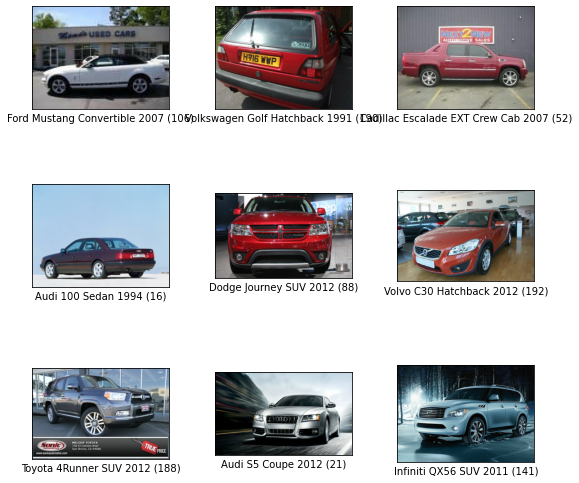

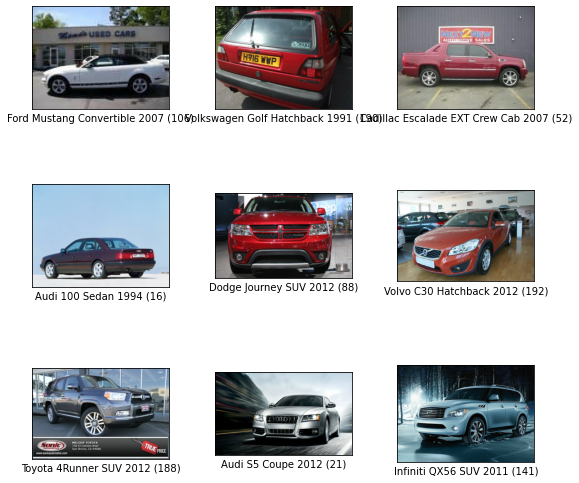

In [4]:
# 훈련용 데이터셋 확인 -> 각 이미지의 클래스와 인덱스 확인 가능
tfds.show_examples(ds_train, ds_info)

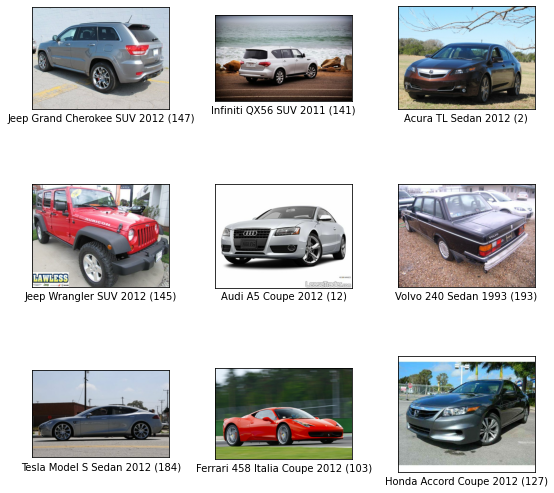

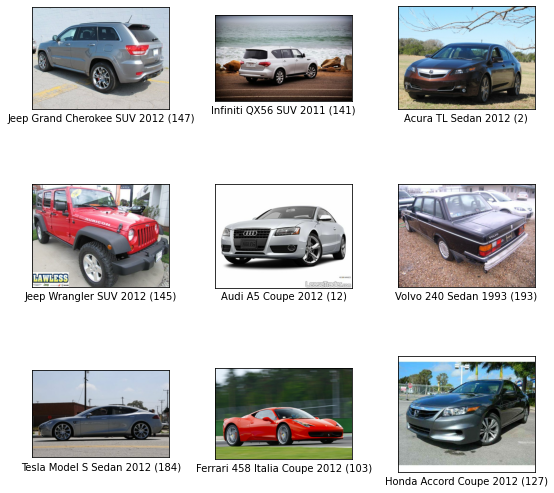

In [5]:
# 평가용 데이터셋 확인
tfds.show_examples(ds_test, ds_info)

In [6]:
# 데이터셋의 메타 정보 조회 -> features의 구성요소 확인
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

#### bbox란?
- `bbox`(바운딩 박스)는 물체의 위치를 사각형 영역으로 표기하는 방법으로 바운딩 박스를 `minmax` 방식으로 표시함.  
- `minmax`는 바운딩 박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법으로, 좌표의 절대값이 아니라 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적임.  
- `minmax`외에도 `xywh` 방법 등이 존재함.  

주어진 데이터셋에서 `BBoxFeature`타입으로 표기된 `bbox` 필드는 height를 첫번째 axis로 삼고있어 [minY, minX, maxY, maxX]를 의미함.  

(참고) [BBoxFeautre](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)  



#### CAM을 위한 모델 만들기
미리 `imagenet` 데이터에 훈련된 `resnet50`을 기반으로 활용함.  
이후 pooling layer뒤에 소프트 맥스 레이어를 붙여 Grad-CAM 모델 생성함.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

#### CAM 모델 학습

In [9]:
# 학습, 검증 데이터에 normalizing과 resize를 포함한 전처리 수행
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 80s 157ms/step - loss: 4.1403 - accuracy: 0.1682 - val_loss: 5.4114 - val_accuracy: 0.0090
Epoch 2/15
509/509 [==============================] - 82s 161ms/step - loss: 1.5988 - accuracy: 0.6478 - val_loss: 2.0469 - val_accuracy: 0.4882
Epoch 3/15
509/509 [==============================] - 82s 161ms/step - loss: 0.5559 - accuracy: 0.9024 - val_loss: 1.3453 - val_accuracy: 0.6503
Epoch 4/15
509/509 [==============================] - 80s 156ms/step - loss: 0.1543 - accuracy: 0.9843 - val_loss: 1.0371 - val_accuracy: 0.7271
Epoch 5/15
509/509 [==============================] - 80s 156ms/step - loss: 0.0449 - accuracy: 0.9986 - val_loss: 0.9958 - val_accuracy: 0.7381
Epoch 6/15
509/509 [==============================] - 80s 157ms/step - loss: 0.0227 - accuracy: 0.9996 - val_loss: 0.9834 - val_accuracy: 0.7414
Epoch 7/15
509/509 [==============================] - 80s 157ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.9812 - val_ac

In [13]:
# 학습된 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


### CAM 구현
학습한 모델을 활용하여 CAM 생성

In [14]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3

urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

130


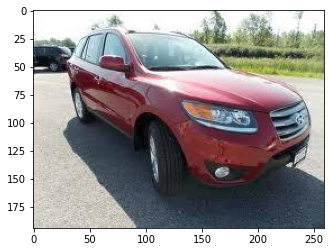

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [17]:
# 이전에 학습한 모델 불러오기
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :] # 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델 정의
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [19]:
# CAM이미지를 원본과 합치기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

Text(0.5, 1.0, 'blended_image')

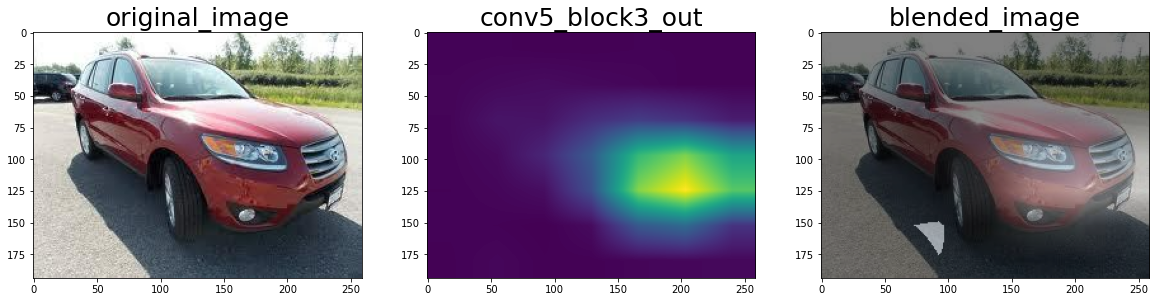

In [20]:
cam_image = generate_cam(cam_model, item)

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1);plt.imshow(item['image']); plt.title('original_image', fontsize=25)
plt.subplot(1,3,2);plt.imshow(cam_image); plt.title('conv5_block3_out', fontsize=25)
plt.subplot(1,3,3);plt.imshow(blended_image); plt.title('blended_image', fontsize=25)

### Grad-CAM 구현

In [21]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] 
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0] 

    weights = np.mean(grad_val, axis=(0, 1)) 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

Text(0.5, 1.0, 'blended_image')

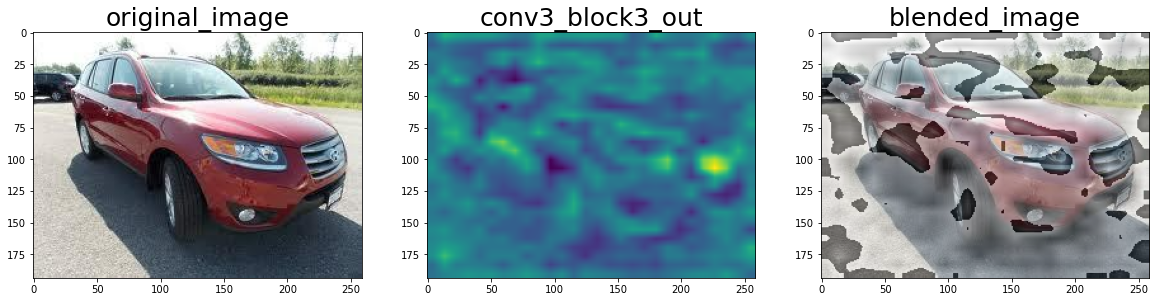

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1);plt.imshow(item['image']); plt.title('original_image', fontsize=25)
plt.subplot(1,3,2);plt.imshow(grad_cam_image); plt.title('conv3_block3_out', fontsize=25)
plt.subplot(1,3,3);plt.imshow(grad_blended_image); plt.title('blended_image', fontsize=25)

Text(0.5, 1.0, 'blended_image')

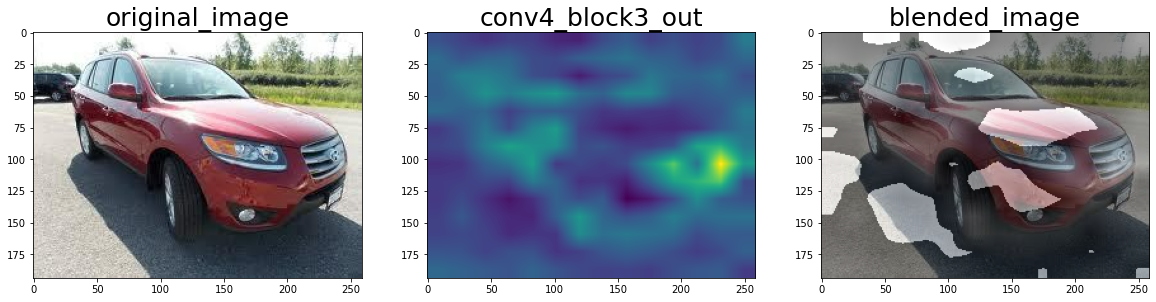

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1);plt.imshow(item['image']); plt.title('original_image', fontsize=25)
plt.subplot(1,3,2);plt.imshow(grad_cam_image); plt.title('conv4_block3_out', fontsize=25)
plt.subplot(1,3,3);plt.imshow(grad_blended_image); plt.title('blended_image', fontsize=25)

Text(0.5, 1.0, 'blended_image')

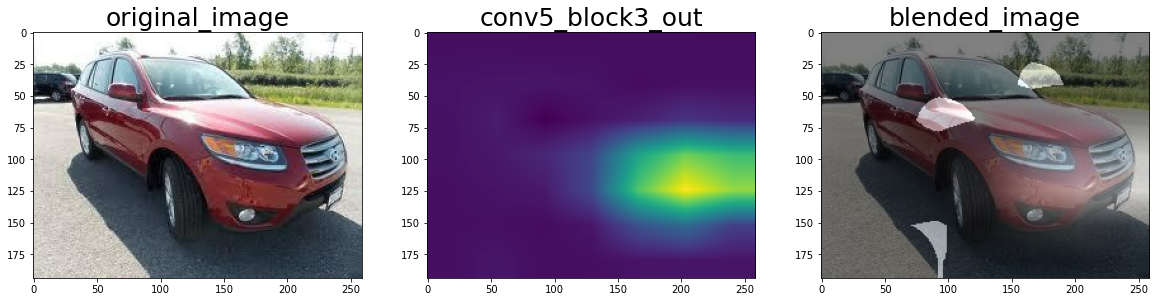

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1);plt.imshow(item['image']); plt.title('original_image', fontsize=25)
plt.subplot(1,3,2);plt.imshow(grad_cam_image); plt.title('conv5_block3_out', fontsize=25)
plt.subplot(1,3,3);plt.imshow(grad_blended_image); plt.title('blended_image', fontsize=25)

### CAM 평가

#### 바운딩 박스 구하기

In [25]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

##### CAM

In [26]:
image = copy.deepcopy(item['image'])
cam_rect = get_bbox(cam_image)
cam_rect

array([[ 69, 175],
       [ 69,  49],
       [257,  49],
       [257, 175]])

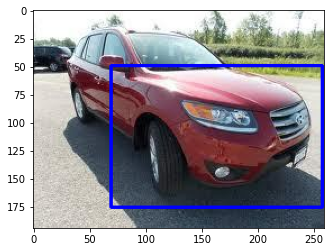

In [27]:
cam_with_bound = cv2.drawContours(image,[cam_rect],0,(0,0,255),2)
plt.imshow(cam_with_bound)

##### Grad-CAM

In [28]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ 75,  54],
       [258,  54],
       [258, 176],
       [ 75, 176]])

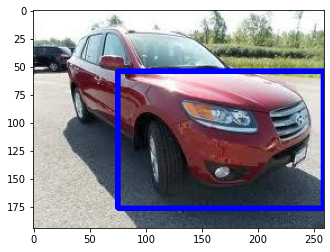

In [29]:
gradcam_with_bound = cv2.drawContours(image,[grad_rect],0,(0,0,255),3)
plt.imshow(gradcam_with_bound)

#### IoU 구하기

메타 정보에 존재해있던 item['bbox']는 (y_min, x_min, y_max, x_max)형태를 가짐.   
반면 위에서 구한 bounding box, rect는 (y,x)의 형태를 가짐.  

In [30]:
print(cam_rect, "\n")  
print(item['bbox'])

[[ 69 175]
 [ 69  49]
 [257  49]
 [257 175]] 

[0.08762886 0.11969112 0.8556701  0.98841697]


따라서 이 둘을 비교하기 위해서 둘의 shpae을 동일하게 맞추는 작업을 수행하는 `rect_to_minmax` 함수생성  

정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 `get_iou()` 함수 생성  

In [31]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  
        rect[:,0].min()/float(image.shape[1]), 
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,0].max()/float(image.shape[1]) 
    ]
    return bbox

In [32]:
camrect_bbox = rect_to_minmax(cam_rect, item['image'])
print(camrect_bbox)

[0.25257731958762886, 0.26640926640926643, 0.9020618556701031, 0.9922779922779923]


In [33]:
gradcamrect_bbox = rect_to_minmax(grad_rect, item['image'])
print(gradcamrect_bbox)

[0.27835051546391754, 0.28957528957528955, 0.9072164948453608, 0.9961389961389961]


In [34]:
def get_iou(gt_bbox, pred_bbox):
    minx = min(gt_bbox[1], pred_bbox[1])
    maxx = min(gt_bbox[3], pred_bbox[3])
    miny = min(gt_bbox[0], pred_bbox[0])
    maxy = min(gt_bbox[2], pred_bbox[2])
    
    intersection = max(0, maxx - minx) * max(0, maxy - miny)
    gt_bboxArea = (gt_bbox[2] - gt_bbox[0]) *  (gt_bbox[3] - gt_bbox[1])
    pred_bboxArea = (pred_bbox[2] - pred_bbox[0]) *  (pred_bbox[3] - pred_bbox[1])
    
    iou = intersection / float(gt_bboxArea+ pred_bboxArea - intersection)
    return iou

참고 : [다양한 IOU(Intersection over Union) 구하는 법](https://gaussian37.github.io/math-algorithm-iou/)

In [38]:
get_iou(item['bbox'], camrect_bbox)

1.4152734792542516

In [39]:
get_iou(item['bbox'], gradcamrect_bbox)

1.501612388093465

#### CAM vs Grad-CAM
비교결과 Grad-CAM의 성능이 더 좋은 것을 확인 할 수 있음.

Text(0.5, 1.0, 'Grad-CAM')

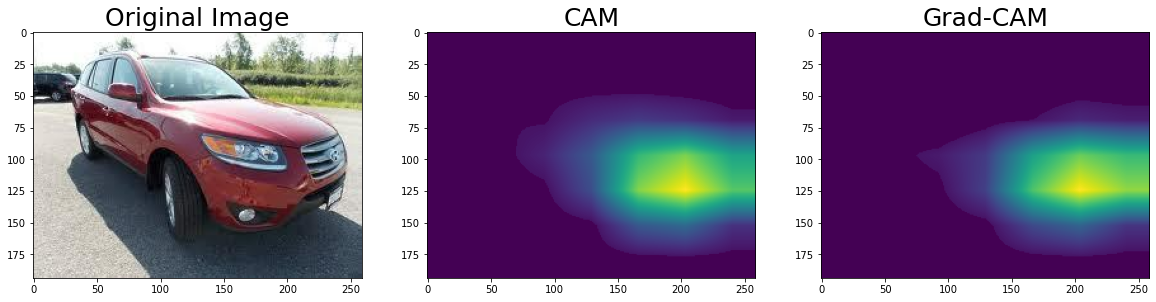

In [35]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1);plt.imshow(item['image']); plt.title('Original Image', fontsize=25)
plt.subplot(1,3,2);plt.imshow(cam_image); plt.title('CAM', fontsize=25)
plt.subplot(1,3,3);plt.imshow(grad_cam_image); plt.title('Grad-CAM', fontsize=25)

##### 원본 이미지 합성

Text(0.5, 1.0, 'Grad-CAM')

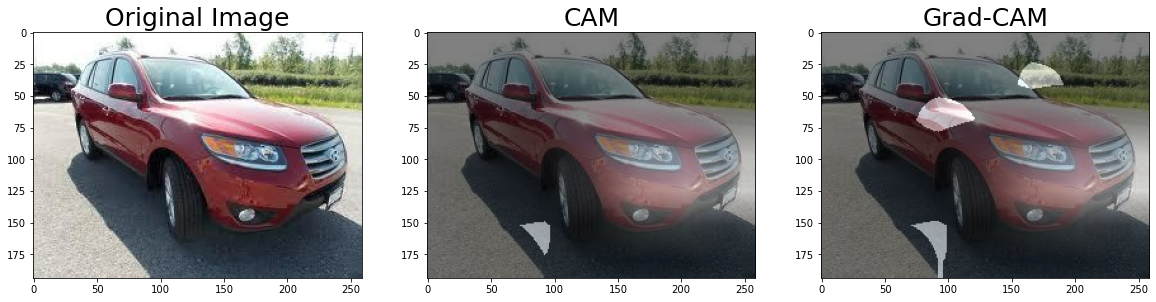

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1);plt.imshow(item['image']); plt.title('Original Image', fontsize=25)
plt.subplot(1,3,2);plt.imshow(blended_image); plt.title('CAM', fontsize=25)
plt.subplot(1,3,3);plt.imshow(grad_blended_image); plt.title('Grad-CAM', fontsize=25)

##### IoU 

Text(0.5, 1.0, 'Grad-CAM')

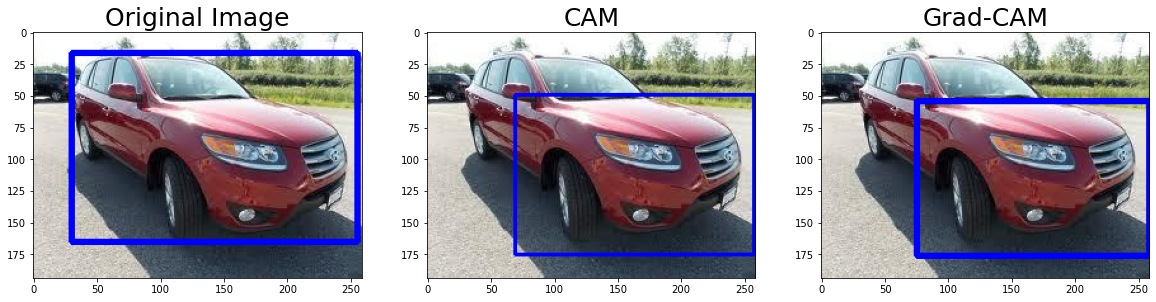

In [37]:
miny = int(item['image'].shape[0] * item['bbox'][0])
maxy = int(item['image'].shape[0] * item['bbox'][2])
minx = int(item['image'].shape[1] * item['bbox'][1])
maxx = int(item['image'].shape[1] * item['bbox'][3])
origin_rect = np.array([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])

image = copy.deepcopy(item['image'])
origin_with_bound = cv2.drawContours(image, [origin_rect], 0, (0, 0, 255), 3)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(origin_with_bound);plt.title('Original Image', fontsize=25)
plt.subplot(1,3,2);plt.imshow(cam_with_bound); plt.title('CAM', fontsize=25)
plt.subplot(1,3,3);plt.imshow(gradcam_with_bound); plt.title('Grad-CAM', fontsize=25)